In [1]:
from silence_tensorflow import silence_tensorflow
silence_tensorflow()

from tensorflow.keras.layers import Layer, Lambda, Conv2D, Dropout,Dense,Activation,Input,GlobalAveragePooling1D, Concatenate, GlobalAveragePooling2D, LayerNormalization, MaxPool2D
from tensorflow.keras.layers import Reshape,Flatten,BatchNormalization,MaxPooling1D,AveragePooling2D,Reshape,Attention, ReLU, Activation, SpatialDropout2D, DepthwiseConv2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import regularizers
from sklearn.model_selection import KFold
import keras.backend as K
from tensorflow.keras.optimizers import Adam
from tqdm.auto import tqdm
import os
from Config import Config
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Mean, CategoricalAccuracy
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from datetime import datetime
import random
import matplotlib.pyplot as plt
from tensorflow.keras.losses import CategoricalCrossentropy, MeanSquaredError

import tensorflow as tf
tf.config.run_functions_eagerly(True)

import warnings
warnings.filterwarnings('always')

from my_models import *
from utils import *

In [2]:
seed_everything(42)

In [3]:
DATA_ROOT = 'TIMNET-dataset'
DATA_PATH = 'RAVDESS'
CLASS_LABELS = Config.RAVDESS_LABELS
k = 10

model_name = 'exp1-remove DWSCNN'
feature_name = 'mfcc'

learning_rate=0.001
beta_1=0.975
beta_2=0.932
epsilon=1e-8

EPOCHS = 300
BATCH = 32

In [4]:
class removeDWSCNN(tf.keras.Model):

  def __init__(self, dim_capsule=64, n_channels=6, kernel_size=3, strides=1, padding='valid'):
    super().__init__()
    
    self.layer = Sequential([
        Reshape(target_shape=[-1, dim_capsule]),
        Lambda(function=PrimaryCapssquash)
    ])
    
  def call(self, inputs):
    return self.layer(inputs)

In [5]:
class Model(tf.keras.Model):

  def __init__(self, num_classes):
    super().__init__()
    
    self.conv1 = Sequential([
      Conv2D(filters=64, kernel_size=3),
      BatchNormalization(axis=1),
      Activation('elu'),
      AveragePooling2D(),
      SpatialDropout2D(0.2)
    ])
    
    self.conv2 = Sequential([
      Conv2D(filters=64, kernel_size=3),
      BatchNormalization(axis=1),
      Activation('elu'),
      AveragePooling2D(),
      SpatialDropout2D(0.2),
    ])
    
    self.conv3 = Sequential([
      Conv2D(filters=64, kernel_size=3, dilation_rate=2),
      BatchNormalization(axis=1),
      Activation('elu'),
      AveragePooling2D(),
      SpatialDropout2D(0.2),
    ])
  
    # Q, V, K
    self.attention = Attention(use_scale=True)
    self.LN = LayerNormalization()
    self.lamb = Lambda(lambda x: tf.multiply(x[0], x[1]))
    
    self.cbam = CBAM(64) # sharing
    self.reshape = Reshape(target_shape=[-1, 64])
    
    self.conv4 = removeDWSCNN()
    self.spatial_attn = SpatialGate()
  
    self.capsule = Capsule(6,64,3,True)
    self.gap = GlobalAveragePooling1D()
    self.dropout = Dropout(0.2)
    self.classifier = Dense(num_classes, activation='softmax')
    
    
  def call(self, inputs):
    x = inputs
    forward = x
    backward = tf.reverse(inputs, axis=[2])
    
    fx = self.conv1(forward)
    fx += self.cbam(fx)
    bx = self.conv2(backward)
    bx += self.cbam(bx)
    cross_attn_out = self.attention([fx, bx, bx]) # Q, K==V
    fx += cross_attn_out
    
    fx = self.conv3(fx)
    fx += self.cbam(fx)
    
    cap = self.conv4(fx)
    
    sa = self.attention([cap, cap, cap])
    sa = self.LN(sa)
    
    sa = self.lamb([cap, sa])
    sa = tf.expand_dims(sa, axis=-1)
    sa += self.spatial_attn(sa)
    cap = tf.squeeze(sa, axis=-1)
    
    capsule = self.capsule(cap)
    
    gap = self.gap(capsule)
    drop = self.dropout(gap)
    
    output_softmax = self.classifier(drop)
    return output_softmax

In [6]:
model = Model(len(CLASS_LABELS))
model.build(input_shape=(None, 196, 39, 1))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 97, 18, 64)        1416      
                                                                 
 sequential_1 (Sequential)   (None, 97, 18, 64)        1416      
                                                                 
 sequential_2 (Sequential)   (None, 46, 7, 64)         37300     
                                                                 
 attention (Attention)       multiple                  1         
                                                                 
 layer_normalization (LayerN  multiple                 128       
 ormalization)                                                   
                                                                 
 lambda (Lambda)             multiple                  0         
                                                             

In [7]:
def margin_loss(y_true, y_pred):
    """
        Margin Loss
        :param y_true: [None, n_classes]
        :param y_pred: [None, num_capsule]
        :return: a scalar loss value.
    """
    L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))

    return K.mean(K.sum(L, 1))

In [8]:
@tf.function
def train_step(model, optimizer, x, labels):
    with tf.GradientTape() as tape:
        # 미분 계산
        predictions = model(x, training=True)
        loss1 = margin_loss(labels, predictions)
        loss2 = MeanSquaredError()(labels, predictions)
        
        loss = loss1*1. + loss2*0.392
        
    grad = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grad, model.trainable_variables))     # 신경망 파라미터 업데이트
    
    acc = tf.keras.metrics.CategoricalAccuracy()
    acc.update_state(labels, predictions)
    accuracy = acc.result().numpy()
    
    return loss, accuracy*100

def test_step(model, x, labels):
    predictions = model(x)
    loss1 = margin_loss(labels, predictions)
    loss2 = MeanSquaredError()(labels, predictions)
    loss = loss1*1. + loss2*0.392
    
    acc = tf.keras.metrics.CategoricalAccuracy()
    acc.update_state(labels, predictions)
    accuracy = acc.result().numpy()
    
    return loss, accuracy*100, predictions

In [9]:
# Read data
with open(f'{DATA_ROOT}/{DATA_PATH}.npy', 'rb') as f:
    x = np.load(f)
    y = np.load(f)

y = to_categorical(y,num_classes=len(CLASS_LABELS))

In [10]:
LEARNING_RATE_DECAY_PARAMETERS = -0.15
LEARNING_RATE_DECAY_STRATPOINT = 50
LEARNING_RATE_DECAY_STEP = 20


def scheduler(epoch, lr):
    if epoch < LEARNING_RATE_DECAY_STRATPOINT:
        return lr
    else:
        if epoch % LEARNING_RATE_DECAY_STEP == 0:
            lr = lr * tf.math.exp(LEARNING_RATE_DECAY_PARAMETERS)
    return lr

In [11]:
# Smooth label operation
def smooth_labels(labels, factor=0.1):
    """
        smooth the labels
        returned the smoothed labels
    """
    labels *= (1 - factor)
    labels += (factor / labels.shape[1])
    return labels

In [12]:
from discord_notice import start, end
# start()

A Jupyter Widget

A Jupyter Widget

1/300 lr=0.00100 - loss:0.631, acc:17.912, val_loss:0.630, val_acc:21.875
Best loss:4144959.000, Best accuracy:-1.000, Best F1-score:-1.000
2/300 lr=0.00100 - loss:0.618, acc:25.229, val_loss:0.613, val_acc:26.875
Best loss:0.630, Best accuracy:21.875, Best F1-score:0.144
3/300 lr=0.00100 - loss:0.607, acc:26.143, val_loss:0.603, val_acc:28.750
Best loss:0.613, Best accuracy:26.875, Best F1-score:0.198
4/300 lr=0.00100 - loss:0.602, acc:27.973, val_loss:0.598, val_acc:30.000
Best loss:0.603, Best accuracy:28.750, Best F1-score:0.214
5/300 lr=0.00100 - loss:0.599, acc:26.982, val_loss:0.586, val_acc:33.750
Best loss:0.598, Best accuracy:30.000, Best F1-score:0.248
6/300 lr=0.00100 - loss:0.584, acc:30.488, val_loss:0.580, val_acc:34.375
Best loss:0.586, Best accuracy:33.750, Best F1-score:0.285
7/300 lr=0.00100 - loss:0.580, acc:32.393, val_loss:0.581, val_acc:35.000
Best loss:0.580, Best accuracy:34.375, Best F1-score:0.291
8/300 lr=0.00100 - loss:0.569, acc:34.756, val_loss:0.549, val

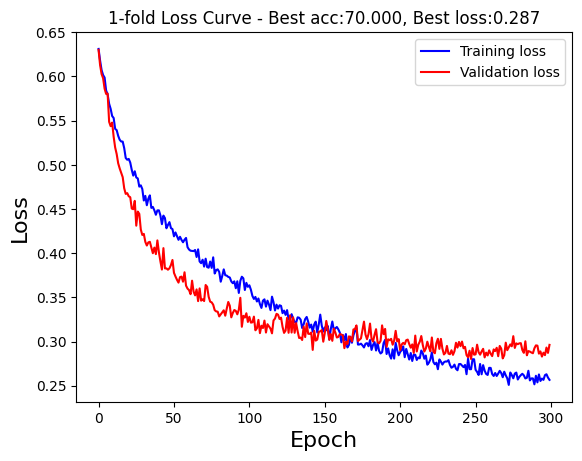

A Jupyter Widget

1/300 lr=0.00100 - loss:0.630, acc:17.759, val_loss:0.638, val_acc:22.500
Best loss:4144959.000, Best accuracy:-1.000, Best F1-score:-1.000
2/300 lr=0.00100 - loss:0.619, acc:23.247, val_loss:0.626, val_acc:26.875
Best loss:0.638, Best accuracy:22.500, Best F1-score:0.166
3/300 lr=0.00100 - loss:0.606, acc:26.753, val_loss:0.610, val_acc:33.125
Best loss:0.626, Best accuracy:26.875, Best F1-score:0.204
4/300 lr=0.00100 - loss:0.594, acc:28.049, val_loss:0.596, val_acc:32.500
Best loss:0.610, Best accuracy:33.125, Best F1-score:0.256
5/300 lr=0.00100 - loss:0.585, acc:28.506, val_loss:0.580, val_acc:34.375
Best loss:0.610, Best accuracy:33.125, Best F1-score:0.256
6/300 lr=0.00100 - loss:0.580, acc:30.259, val_loss:0.572, val_acc:35.000
Best loss:0.580, Best accuracy:34.375, Best F1-score:0.283
7/300 lr=0.00100 - loss:0.570, acc:34.070, val_loss:0.567, val_acc:35.000
Best loss:0.572, Best accuracy:35.000, Best F1-score:0.286
8/300 lr=0.00100 - loss:0.564, acc:33.613, val_loss:0.556, val

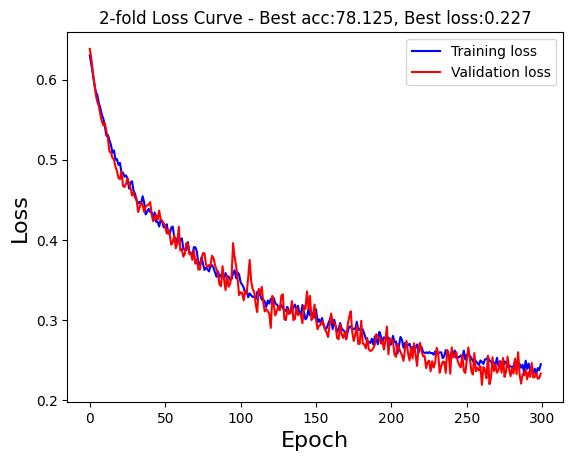

A Jupyter Widget

1/300 lr=0.00100 - loss:0.631, acc:16.845, val_loss:0.631, val_acc:16.875
Best loss:4144959.000, Best accuracy:-1.000, Best F1-score:-1.000
2/300 lr=0.00100 - loss:0.620, acc:22.790, val_loss:0.619, val_acc:22.500
Best loss:0.631, Best accuracy:16.875, Best F1-score:0.090
3/300 lr=0.00100 - loss:0.612, acc:24.543, val_loss:0.608, val_acc:26.250
Best loss:0.619, Best accuracy:22.500, Best F1-score:0.162
4/300 lr=0.00100 - loss:0.599, acc:27.439, val_loss:0.595, val_acc:27.500
Best loss:0.608, Best accuracy:26.250, Best F1-score:0.228
5/300 lr=0.00100 - loss:0.590, acc:28.963, val_loss:0.583, val_acc:30.625
Best loss:0.595, Best accuracy:27.500, Best F1-score:0.220
6/300 lr=0.00100 - loss:0.582, acc:31.250, val_loss:0.563, val_acc:37.500
Best loss:0.583, Best accuracy:30.625, Best F1-score:0.269
7/300 lr=0.00100 - loss:0.573, acc:32.774, val_loss:0.559, val_acc:33.750
Best loss:0.563, Best accuracy:37.500, Best F1-score:0.310
8/300 lr=0.00100 - loss:0.567, acc:33.841, val_loss:0.546, val

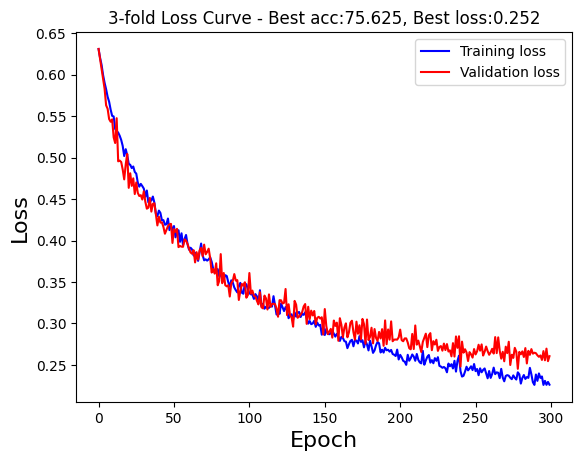

A Jupyter Widget

1/300 lr=0.00100 - loss:0.632, acc:17.226, val_loss:0.631, val_acc:24.375
Best loss:4144959.000, Best accuracy:-1.000, Best F1-score:-1.000
2/300 lr=0.00100 - loss:0.621, acc:23.018, val_loss:0.616, val_acc:26.875
Best loss:0.631, Best accuracy:24.375, Best F1-score:0.180
3/300 lr=0.00100 - loss:0.611, acc:25.991, val_loss:0.602, val_acc:25.625
Best loss:0.616, Best accuracy:26.875, Best F1-score:0.215
4/300 lr=0.00100 - loss:0.599, acc:28.201, val_loss:0.592, val_acc:26.250
Best loss:0.616, Best accuracy:26.875, Best F1-score:0.215
5/300 lr=0.00100 - loss:0.590, acc:29.726, val_loss:0.576, val_acc:30.625
Best loss:0.616, Best accuracy:26.875, Best F1-score:0.215
6/300 lr=0.00100 - loss:0.581, acc:31.479, val_loss:0.562, val_acc:35.000
Best loss:0.576, Best accuracy:30.625, Best F1-score:0.219
7/300 lr=0.00100 - loss:0.572, acc:32.774, val_loss:0.556, val_acc:33.750
Best loss:0.562, Best accuracy:35.000, Best F1-score:0.279
8/300 lr=0.00100 - loss:0.567, acc:33.918, val_loss:0.544, val

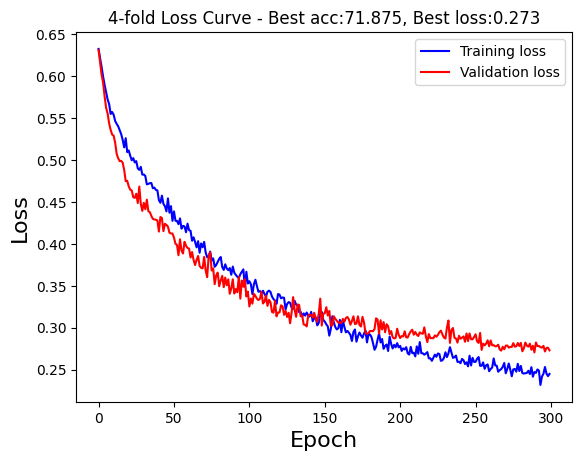

A Jupyter Widget

1/300 lr=0.00100 - loss:0.635, acc:16.159, val_loss:0.640, val_acc:16.875
Best loss:4144959.000, Best accuracy:-1.000, Best F1-score:-1.000
2/300 lr=0.00100 - loss:0.625, acc:21.723, val_loss:0.627, val_acc:25.000
Best loss:0.640, Best accuracy:16.875, Best F1-score:0.116
3/300 lr=0.00100 - loss:0.616, acc:23.552, val_loss:0.612, val_acc:26.250
Best loss:0.627, Best accuracy:25.000, Best F1-score:0.198
4/300 lr=0.00100 - loss:0.605, acc:24.390, val_loss:0.598, val_acc:27.500
Best loss:0.612, Best accuracy:26.250, Best F1-score:0.172
5/300 lr=0.00100 - loss:0.595, acc:26.448, val_loss:0.579, val_acc:35.000
Best loss:0.598, Best accuracy:27.500, Best F1-score:0.223
6/300 lr=0.00100 - loss:0.589, acc:26.982, val_loss:0.573, val_acc:32.500
Best loss:0.579, Best accuracy:35.000, Best F1-score:0.261
7/300 lr=0.00100 - loss:0.583, acc:30.259, val_loss:0.568, val_acc:35.000
Best loss:0.579, Best accuracy:35.000, Best F1-score:0.261
8/300 lr=0.00100 - loss:0.580, acc:28.430, val_loss:0.554, val

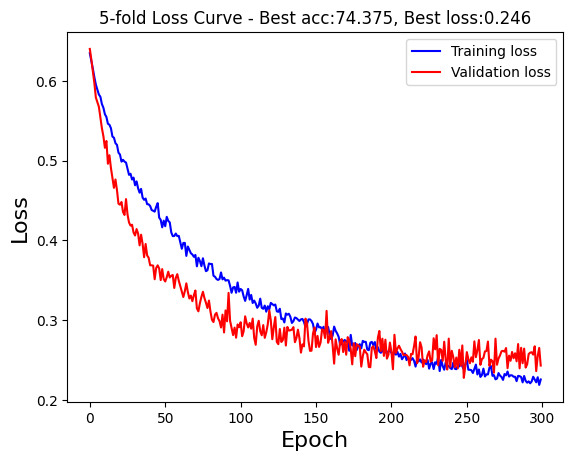

A Jupyter Widget

1/300 lr=0.00100 - loss:0.632, acc:17.149, val_loss:0.637, val_acc:16.875
Best loss:4144959.000, Best accuracy:-1.000, Best F1-score:-1.000
2/300 lr=0.00100 - loss:0.622, acc:23.323, val_loss:0.625, val_acc:20.625
Best loss:0.637, Best accuracy:16.875, Best F1-score:0.083
3/300 lr=0.00100 - loss:0.611, acc:25.152, val_loss:0.610, val_acc:22.500
Best loss:0.625, Best accuracy:20.625, Best F1-score:0.126
4/300 lr=0.00100 - loss:0.604, acc:24.924, val_loss:0.598, val_acc:25.000
Best loss:0.610, Best accuracy:22.500, Best F1-score:0.148
5/300 lr=0.00100 - loss:0.594, acc:26.905, val_loss:0.590, val_acc:25.000
Best loss:0.598, Best accuracy:25.000, Best F1-score:0.179
6/300 lr=0.00100 - loss:0.588, acc:29.116, val_loss:0.580, val_acc:28.750
Best loss:0.598, Best accuracy:25.000, Best F1-score:0.179
7/300 lr=0.00100 - loss:0.585, acc:30.869, val_loss:0.574, val_acc:31.875
Best loss:0.580, Best accuracy:28.750, Best F1-score:0.212
8/300 lr=0.00100 - loss:0.581, acc:30.259, val_loss:0.570, val

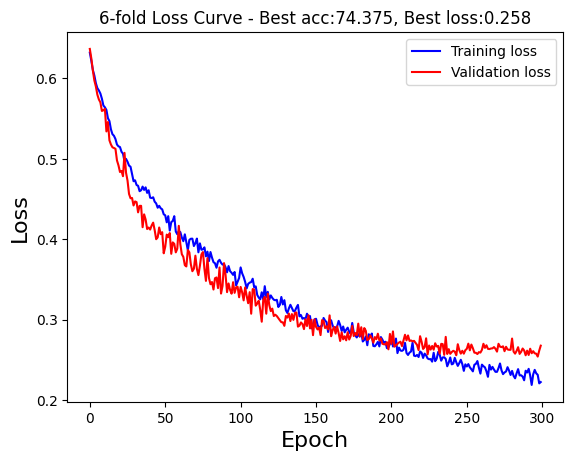

A Jupyter Widget

1/300 lr=0.00100 - loss:0.632, acc:16.387, val_loss:0.631, val_acc:25.625
Best loss:4144959.000, Best accuracy:-1.000, Best F1-score:-1.000
2/300 lr=0.00100 - loss:0.621, acc:21.951, val_loss:0.617, val_acc:28.750
Best loss:0.631, Best accuracy:25.625, Best F1-score:0.177
3/300 lr=0.00100 - loss:0.612, acc:25.305, val_loss:0.605, val_acc:26.250
Best loss:0.617, Best accuracy:28.750, Best F1-score:0.201
4/300 lr=0.00100 - loss:0.601, acc:27.591, val_loss:0.592, val_acc:30.625
Best loss:0.617, Best accuracy:28.750, Best F1-score:0.201
5/300 lr=0.00100 - loss:0.592, acc:28.811, val_loss:0.577, val_acc:32.500
Best loss:0.592, Best accuracy:30.625, Best F1-score:0.256
6/300 lr=0.00100 - loss:0.582, acc:33.308, val_loss:0.566, val_acc:36.250
Best loss:0.577, Best accuracy:32.500, Best F1-score:0.277
7/300 lr=0.00100 - loss:0.575, acc:32.622, val_loss:0.554, val_acc:34.375
Best loss:0.566, Best accuracy:36.250, Best F1-score:0.310
8/300 lr=0.00100 - loss:0.562, acc:35.366, val_loss:0.546, val

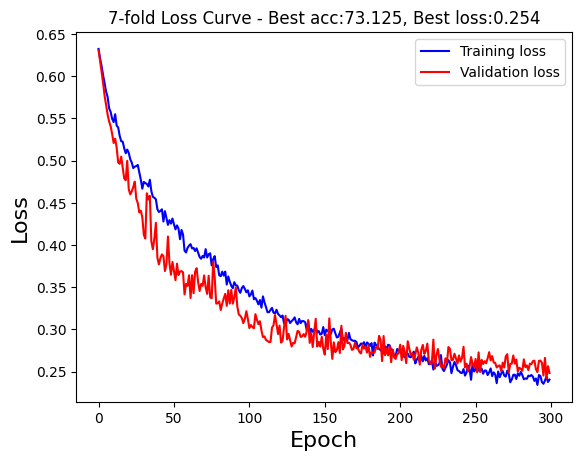

A Jupyter Widget

1/300 lr=0.00100 - loss:0.631, acc:15.777, val_loss:0.626, val_acc:21.250
Best loss:4144959.000, Best accuracy:-1.000, Best F1-score:-1.000
2/300 lr=0.00100 - loss:0.619, acc:21.570, val_loss:0.611, val_acc:20.625
Best loss:0.626, Best accuracy:21.250, Best F1-score:0.136
3/300 lr=0.00100 - loss:0.605, acc:26.143, val_loss:0.596, val_acc:22.500
Best loss:0.626, Best accuracy:21.250, Best F1-score:0.136
4/300 lr=0.00100 - loss:0.599, acc:26.905, val_loss:0.579, val_acc:25.000
Best loss:0.596, Best accuracy:22.500, Best F1-score:0.163
5/300 lr=0.00100 - loss:0.589, acc:29.649, val_loss:0.574, val_acc:30.625
Best loss:0.579, Best accuracy:25.000, Best F1-score:0.172
6/300 lr=0.00100 - loss:0.583, acc:31.250, val_loss:0.560, val_acc:34.375
Best loss:0.574, Best accuracy:30.625, Best F1-score:0.232
7/300 lr=0.00100 - loss:0.572, acc:34.985, val_loss:0.565, val_acc:32.500
Best loss:0.560, Best accuracy:34.375, Best F1-score:0.276
8/300 lr=0.00100 - loss:0.569, acc:32.241, val_loss:0.545, val

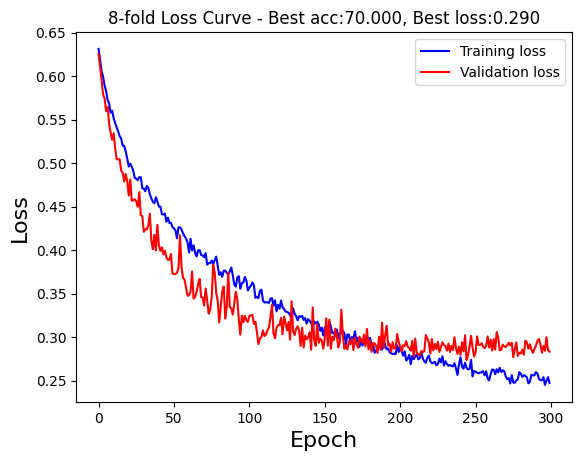

A Jupyter Widget

1/300 lr=0.00100 - loss:0.635, acc:15.320, val_loss:0.632, val_acc:23.125
Best loss:4144959.000, Best accuracy:-1.000, Best F1-score:-1.000
2/300 lr=0.00100 - loss:0.623, acc:21.570, val_loss:0.617, val_acc:24.375
Best loss:0.632, Best accuracy:23.125, Best F1-score:0.167
3/300 lr=0.00100 - loss:0.611, acc:23.628, val_loss:0.602, val_acc:23.125
Best loss:0.617, Best accuracy:24.375, Best F1-score:0.164
4/300 lr=0.00100 - loss:0.603, acc:26.601, val_loss:0.587, val_acc:30.000
Best loss:0.617, Best accuracy:24.375, Best F1-score:0.164
5/300 lr=0.00100 - loss:0.593, acc:29.726, val_loss:0.579, val_acc:27.500
Best loss:0.587, Best accuracy:30.000, Best F1-score:0.253
6/300 lr=0.00100 - loss:0.588, acc:27.134, val_loss:0.569, val_acc:33.125
Best loss:0.587, Best accuracy:30.000, Best F1-score:0.253
7/300 lr=0.00100 - loss:0.584, acc:29.878, val_loss:0.561, val_acc:34.375
Best loss:0.569, Best accuracy:33.125, Best F1-score:0.273
8/300 lr=0.00100 - loss:0.581, acc:29.726, val_loss:0.565, val

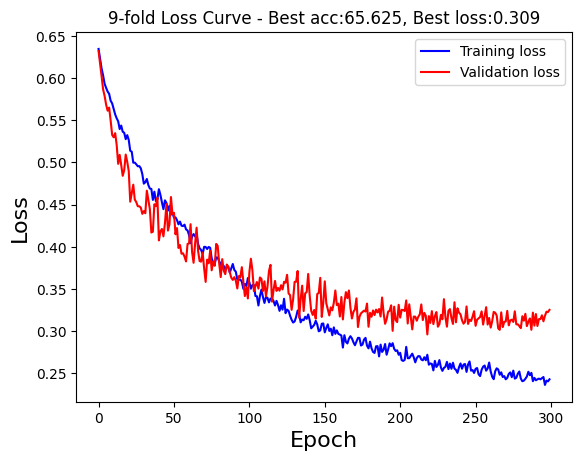

A Jupyter Widget

1/300 lr=0.00100 - loss:0.632, acc:17.988, val_loss:0.625, val_acc:23.750
Best loss:4144959.000, Best accuracy:-1.000, Best F1-score:-1.000
2/300 lr=0.00100 - loss:0.621, acc:21.723, val_loss:0.613, val_acc:28.125
Best loss:0.625, Best accuracy:23.750, Best F1-score:0.128
3/300 lr=0.00100 - loss:0.612, acc:23.095, val_loss:0.602, val_acc:30.625
Best loss:0.613, Best accuracy:28.125, Best F1-score:0.180
4/300 lr=0.00100 - loss:0.601, acc:26.448, val_loss:0.588, val_acc:36.250
Best loss:0.602, Best accuracy:30.625, Best F1-score:0.226
5/300 lr=0.00100 - loss:0.594, acc:28.277, val_loss:0.572, val_acc:37.500
Best loss:0.588, Best accuracy:36.250, Best F1-score:0.302
6/300 lr=0.00100 - loss:0.582, acc:30.564, val_loss:0.559, val_acc:38.125
Best loss:0.572, Best accuracy:37.500, Best F1-score:0.328
7/300 lr=0.00100 - loss:0.577, acc:31.631, val_loss:0.546, val_acc:37.500
Best loss:0.559, Best accuracy:38.125, Best F1-score:0.308
8/300 lr=0.00100 - loss:0.566, acc:33.232, val_loss:0.538, val

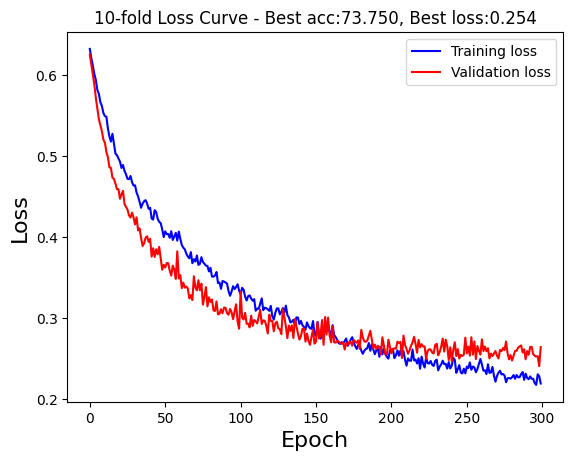

In [13]:
import tensorflow_addons as tfa
from keras.models import load_model

emotions_groundtruth_list = np.array([])
predicted_emotions_list = np.array([])

fold_acc = []

kfold = KFold(n_splits=k, shuffle=True, random_state=98)

for i, (train, test) in tqdm(enumerate(kfold.split(x, y)), desc=f'Training {k}-Fold.....'):
    save_path = f'Models/{DATA_PATH}'
    os.makedirs(save_path, exist_ok=True)
    h5_path = f'{save_path}/{model_name}_{i}-fold_.h5'
    
    x_train, y_train = x[train], y[train]
    y_train = smooth_labels(y[train], 0.1)
    
    x_test, y_test = x[test], y[test]
    
    x_train = tf.expand_dims(x_train, axis=-1)
    x_test = tf.expand_dims(x_test, axis=-1)
    
    shape = x_train.shape[1:]
    
    optimizer = Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon)
    
    model = Model(len(CLASS_LABELS))
    
    best_test_loss = 0x3f3f3f
    best_test_acc = -1
    best_test_f1 = -1
    
    epoch_losses = []
    valid_losses = []
    
    batch_train = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(2022).batch(BATCH)
    batch_test = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH)
    for epoch in tqdm(range(EPOCHS), desc=f'Fold-{i+1}'):

        train_loss, train_acc = [], []
        for features, labels in batch_train:
            loss, acc = train_step(model, optimizer, features, labels)
            train_loss.append(loss)
            train_acc.append(acc)
            
        test_loss, test_acc, f1s = [], [], []
        for features, labels in batch_test:
            loss, acc, pred = test_step(model, features, labels)
            test_loss.append(loss)
            test_acc.append(acc)
            
            f1_metric = tfa.metrics.F1Score(num_classes=len(CLASS_LABELS), average='weighted')
            f1_metric.update_state(labels, pred)
            f1 = f1_metric.result().numpy()
            f1s.append(f1)
            
        
        epoch_loss = sum(train_loss)/len(train_loss)
        epoch_acc = sum(train_acc)/len(train_acc)
        val_loss = sum(test_loss)/len(test_loss)
        val_acc = sum(test_acc)/len(test_acc)
        f1_score = sum(f1s)/len(f1s)
        
        epoch_losses.append(epoch_loss)
        valid_losses.append(val_loss)
        
        cur_lr = K.eval(optimizer.lr)
        print(f'{epoch+1}/{EPOCHS} lr={cur_lr:.5f} - loss:{epoch_loss:.3f}, acc:{epoch_acc:.3f}, val_loss:{val_loss:.3f}, val_acc:{val_acc:.3f}')
        print(f'Best loss:{best_test_loss:.3f}, Best accuracy:{best_test_acc:.3f}, Best F1-score:{best_test_f1:.3f}')
        
        set_lr = scheduler(epoch, K.eval(optimizer.lr))
        K.set_value(optimizer.learning_rate, set_lr)
        
        if best_test_acc < val_acc:
            best_test_acc = val_acc
            best_test_loss = val_loss
            best_test_f1 = f1_score
            model.save_weights(h5_path)
            
            
    model = Model(len(CLASS_LABELS))
    model.build(input_shape=x_train.shape)
    model.load_weights(h5_path)
    
    for features, labels in batch_test:
        best_pred = model(features, training=False)
        emotions_groundtruth_list = np.append(emotions_groundtruth_list, np.argmax(labels, axis=1))
        predicted_emotions_list = np.append(predicted_emotions_list, np.argmax(best_pred, axis=1))
    
    
    print(f'[*] Done - acc:{best_test_acc:.3f}')
    
    plt.title(f'{i+1}-fold Loss Curve - Best acc:{best_test_acc:.3f}, Best loss:{best_test_loss:.3f}')
    plt.ylabel('Loss', fontsize=16)
    plt.xlabel('Epoch', fontsize=16)
    plt.plot(epoch_losses[:],'b')
    plt.plot(valid_losses[:],'r')
    plt.legend(['Training loss','Validation loss'])

    
    save_fig_path = f'Fig/{DATA_PATH}/training/{model_name}'
    os.makedirs(save_fig_path, exist_ok=True)
    plt.savefig(f'{save_fig_path}/{i+1}-fold.PNG')
    
    plt.show()
    
    fold_acc.append(best_test_acc)

In [14]:
end()

In [15]:
print(f'max:{max(fold_acc)}, min:{min(fold_acc)}, average:{sum(fold_acc)/len(fold_acc)}')

max:78.125, min:65.625, average:72.6875


In [16]:
import warnings
warnings.filterwarnings('always')

Report = classification_report(emotions_groundtruth_list, predicted_emotions_list)

os.makedirs(f'Results/{DATA_PATH}', exist_ok=True)
report_path = f'Results/{DATA_PATH}/{model_name}_{feature_name}_{k}-fold_nomalize.txt'

with open(report_path, "w") as f:
    f.write(Report)

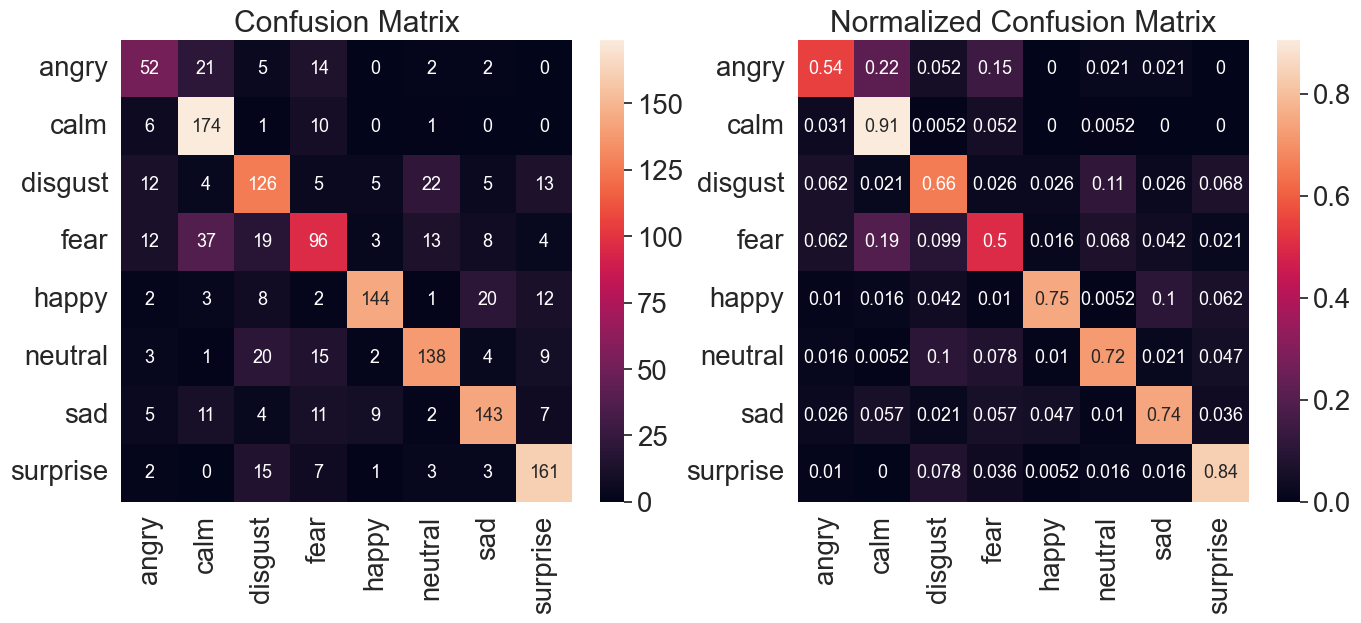

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

emotion_names = CLASS_LABELS


# build confusion matrix and normalized confusion matrix
conf_matrix = confusion_matrix(emotions_groundtruth_list, predicted_emotions_list)
conf_matrix_norm = confusion_matrix(emotions_groundtruth_list, predicted_emotions_list,normalize='true')

# make a confusion matrix with labels using a DataFrame
confmatrix_df = pd.DataFrame(conf_matrix, index=emotion_names, columns=emotion_names)
confmatrix_df_norm = pd.DataFrame(conf_matrix_norm, index=emotion_names, columns=emotion_names)

# plot confusion matrices
plt.figure(figsize=(16,6))
sn.set(font_scale=1.8) # emotion label and title size
plt.subplot(1,2,1)
plt.title('Confusion Matrix')
sn.heatmap(confmatrix_df, annot=True, annot_kws={"size": 13}, fmt='g') #annot_kws is value font
plt.subplot(1,2,2)
plt.title('Normalized Confusion Matrix')
sn.heatmap(confmatrix_df_norm, annot=True, annot_kws={"size": 13}) #annot_kws is value font
plt.savefig(f'Results/{DATA_PATH}/{model_name}_{feature_name}_{k}-fold_confmatrix.pdf')
plt.show()

In [18]:
get_metric_calc(conf_matrix)

WAR(Weighted Average Recall)   : 70.70%
UAR(Unweighted Average Recall) : 70.70%
